In [1]:
import torch
import torch.nn.functional as F
import kornia

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load the camera matrix
intrinsics = np.load('data/normals/camera_intrinsics.npy')  # 4x4
intrinsics = torch.from_numpy(intrinsics)[None, ..., :3, :3] # 1x3x3
print(intrinsics)

tensor([[[277.1281,   0.0000, 160.0000],
         [  0.0000, 289.7056, 120.0000],
         [  0.0000,   0.0000,   1.0000]]])


In [3]:
# load the camera homogeneous transformation
pose = np.load('data/normals/camera_pose.npy')  # 4x4
pose = torch.from_numpy(pose)[None] # 1x4x4
print(pose)

tensor([[[ 0.9728,  0.0000,  0.2316,  1.0314],
         [-0.1911, -0.5649,  0.8027, -0.1995],
         [ 0.1309, -0.8251, -0.5496,  1.8020],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])


In [4]:
# load the depth map
depth_np = cv2.imread('data/normals/depth.png', cv2.IMREAD_UNCHANGED)
depth = kornia.image_to_tensor(depth_np.astype(np.float32), keepdim=False)
print(depth.shape)

# load the surface normals
normals_np = cv2.imread('data/normals/normals.png', cv2.IMREAD_UNCHANGED)
normals = (normals_np.astype(np.float32) - 128.) / 128.
normals = kornia.image_to_tensor(normals, keepdim=False)
print(normals.shape)

torch.Size([1, 1, 240, 320])
torch.Size([1, 3, 240, 320])


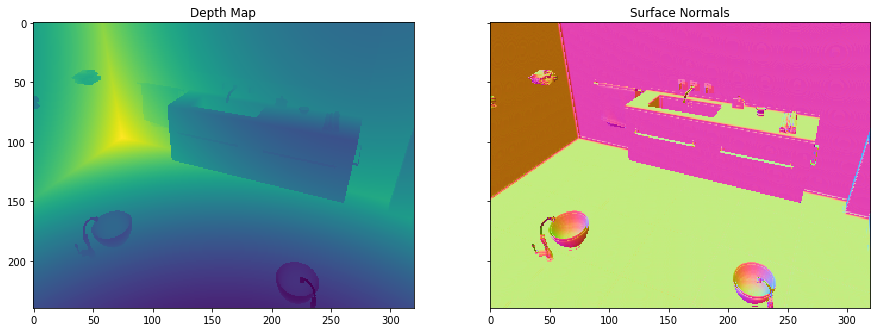

In [5]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)

ax1.imshow(depth_np)
ax1.set_title('Depth Map')

ax2.imshow(normals_np)
ax2.set_title('Surface Normals')
plt.show()

In [6]:
# compute the 3d points from depth map and save pointcloud
points_3d = kornia.depth_to_3d(depth, intrinsics)
print(points_3d.shape)

filename = "pointcloud.ply"
points_3d_save = points_3d[0].permute(1, 2, 0)  # HxWx3
kornia.save_pointcloud_ply(filename, points_3d_save)

torch.Size([1, 3, 240, 320])


![title](data/normals/pointcloud_screeenshot.png)

In [7]:
# compute the normals given the depth map
normals_pred = kornia.depth_to_normals(depth, intrinsics)[:, (2, 1, 0)]
print(normals_pred.shape)
print(normals.shape)

# compute the normals similarity between ground truth
normals_similarity = F.cosine_similarity(normals_pred, normals)
print(normals_similarity.shape)

torch.Size([1, 3, 240, 320])
torch.Size([1, 3, 240, 320])
torch.Size([1, 240, 320])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


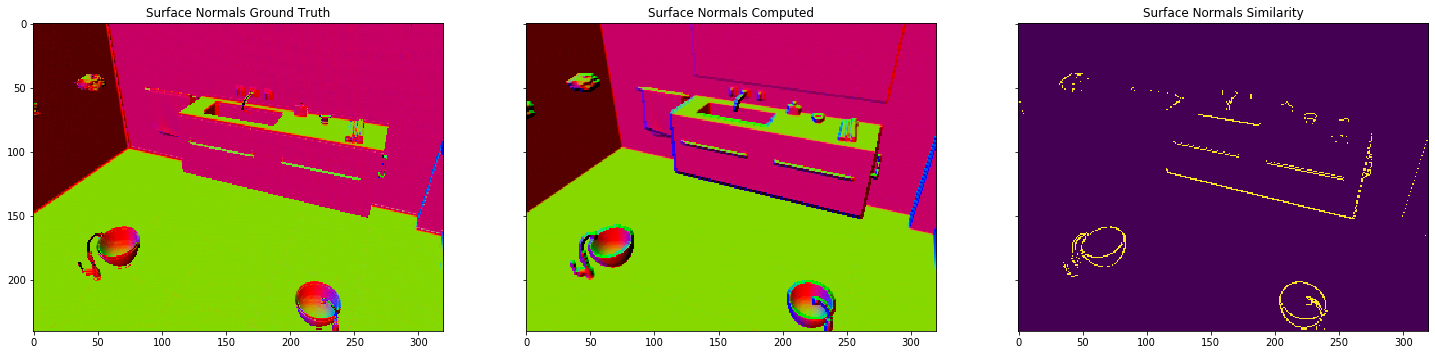

In [8]:
# visualize computed normals and ground truth
normals_vis = kornia.tensor_to_image(normals)
normals_pred_vis = kornia.tensor_to_image(normals_pred)
normals_similarity_vis = kornia.tensor_to_image((normals_similarity[0] < 0).float())

%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_figheight(25)
fig.set_figwidth(25)

ax1.imshow(normals_vis)
ax1.set_title('Surface Normals Ground Truth')

ax2.imshow(normals_pred_vis)
ax2.set_title('Surface Normals Computed')

ax3.imshow(normals_similarity_vis)
ax3.set_title('Surface Normals Similarity')
plt.show()